In [260]:
import os
import librosa
import _pickle as cPickle
from scipy.io.wavfile import read
from pathlib import Path
import warnings
import numpy as np
from sklearn import preprocessing
import python_speech_features as mfcc
from sklearn import metrics
from keras.utils import to_categorical

In [261]:
train_file ="..\\data\\f_list\\wav_list_train.txt"    
test_file ="..\\data\\f_list\\wav_list_test.txt" 
def calculate_delta(array):
    """Calculate and returns the delta of given feature vector matrix"""

    rows,cols = array.shape
    deltas = np.zeros((rows,20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
                first = 0
            else:
                first = i-j
            if i+j > rows -1:
                second = rows -1
            else:
                second = i+j
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas

def extract_features(audio,rate):
    """extract 20 dim mfcc features from an audio, performs CMS and combines 
    delta to make it 40 dim feature vector"""    
    
    mfcc_feat = mfcc.mfcc(audio,rate, 0.025, 0.01,20,appendEnergy = True)
    
    mfcc_feat = preprocessing.scale(mfcc_feat)
    delta = calculate_delta(mfcc_feat)
    combined = np.hstack((mfcc_feat,delta)) 
    return combined
def get_features(file_path): 
    file_paths = open(file_path,'r')
    features_normalize = []
    total_feature = []
    features = np.asarray(())
    for path in file_paths:    
        path = path.strip()
        file_name=os.path.basename(path)
        audio, sr1 = librosa.load(path, sr=44100)
        data=librosa.resample(audio, sr1, 16000)
        vector   = extract_features(data,16000)
        if features.size == 0:
            features = vector
       
        else:
            features = np.vstack((features, vector)) 

        total_feature.append(features)
    return total_feature

In [262]:
def extract_label(file_path): 
    file_paths = open(file_path,'r')
    features_normalize = []
    total_feature = []
    labels = []
    features = np.asarray(())
    for path in file_paths:    
        path = path.strip()
        file_name=os.path.basename(path)
        audio, sr1 = librosa.load(path, sr=44100)
        data=librosa.resample(audio, sr1, 16000)
        vector   = extract_features(data,16000)

        if features.size == 0:
            features = vector

        
        else:
            features = np.vstack((features, vector))


        file_name=os.path.basename(path)

        split_filename=file_name.split('_')

        molecule_name=split_filename[0]

        for r in range(features.shape[0]):

            labels.append(molecule_name)
       
    return labels



In [263]:
from sklearn.preprocessing import LabelEncoder
# Extract features from the training data 
extracted_features_train = get_features(train_file) 
final_features_train = np.vstack(extracted_features_train)
# Extract features from the testing data 
extracted_features_test = get_features(test_file) 
final_features_test = np.vstack(extracted_features_test) 
# Extract labels from the training data 
train_label_value = extract_label(train_file)
train_final_label = np.array(train_label_value)
#print(train_label_value)
# Extract labels from the testing data 
test_label_value = extract_label(test_file)
test_final_label = np.array(test_label_value)
#print(test_final_label)
#print(test_final_label.shape)
x_train = final_features_train
x_test = final_features_test
#print(x_train)
#print(x_test)
y_train = train_final_label 
y_test =  test_final_label
#print(y_train)
#print(y_test)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test  = label_encoder.fit_transform(y_test)
#print(y_train)
#print(y_test)
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)
#print(y_train_hot)
#print(y_test_hot)

In [264]:
import keras
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(16, input_dim=40,activation='sigmoid'))
model.add(Dense(12, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adadelta(),metrics=['accuracy']) 
history=model.fit(x_train, y_train_hot, batch_size=1000, epochs=2500, verbose=1, validation_data=(x_test, y_test_hot))

Train on 23335 samples, validate on 23335 samples
Epoch 1/2500
23335/23335 [==============================] - 0s 19us/step - loss: 0.6720 - accuracy: 0.6087 - val_loss: 0.6495 - val_accuracy: 0.6582
Epoch 2/2500
23335/23335 [==============================] - 0s 13us/step - loss: 0.6453 - accuracy: 0.6582 - val_loss: 0.6429 - val_accuracy: 0.6582
Epoch 3/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.6425 - accuracy: 0.6582 - val_loss: 0.6423 - val_accuracy: 0.6582
Epoch 4/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.6423 - accuracy: 0.6582 - val_loss: 0.6422 - val_accuracy: 0.6582
Epoch 5/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.6423 - accuracy: 0.6582 - val_loss: 0.6422 - val_accuracy: 0.6582
Epoch 6/2500
23335/23335 [==============================] - 0s 11us/step - loss: 0.6422 - accuracy: 0.6582 - val_loss: 0.6421 - val_accuracy: 0.6582
Epoch 7/2500
23335/23335 [==============================

23335/23335 [==============================] - 0s 9us/step - loss: 0.5682 - accuracy: 0.6576 - val_loss: 0.5672 - val_accuracy: 0.6580
Epoch 56/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.5666 - accuracy: 0.6577 - val_loss: 0.5657 - val_accuracy: 0.6581
Epoch 57/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.5650 - accuracy: 0.6578 - val_loss: 0.5645 - val_accuracy: 0.6579
Epoch 58/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.5637 - accuracy: 0.6557 - val_loss: 0.5626 - val_accuracy: 0.6580
Epoch 59/2500
23335/23335 [==============================] - 0s 11us/step - loss: 0.5622 - accuracy: 0.6577 - val_loss: 0.5613 - val_accuracy: 0.6580
Epoch 60/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.5609 - accuracy: 0.6576 - val_loss: 0.5601 - val_accuracy: 0.6579
Epoch 61/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.5596 - accuracy: 0.6585 - val_l

Epoch 110/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.5310 - accuracy: 0.6549 - val_loss: 0.5306 - val_accuracy: 0.6573
Epoch 111/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.5306 - accuracy: 0.6567 - val_loss: 0.5302 - val_accuracy: 0.6573
Epoch 112/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.5302 - accuracy: 0.6572 - val_loss: 0.5298 - val_accuracy: 0.6573
Epoch 113/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.5300 - accuracy: 0.6555 - val_loss: 0.5295 - val_accuracy: 0.6573
Epoch 114/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.5296 - accuracy: 0.6579 - val_loss: 0.5292 - val_accuracy: 0.6573
Epoch 115/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.5293 - accuracy: 0.6545 - val_loss: 0.5289 - val_accuracy: 0.6573
Epoch 116/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.5289 - accuracy:

23335/23335 [==============================] - 0s 7us/step - loss: 0.5180 - accuracy: 0.6566 - val_loss: 0.5177 - val_accuracy: 0.6576
Epoch 165/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.5178 - accuracy: 0.6560 - val_loss: 0.5175 - val_accuracy: 0.6576
Epoch 166/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.5176 - accuracy: 0.6575 - val_loss: 0.5176 - val_accuracy: 0.6574
Epoch 167/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.5175 - accuracy: 0.6549 - val_loss: 0.5172 - val_accuracy: 0.6576
Epoch 168/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.5173 - accuracy: 0.6588 - val_loss: 0.5170 - val_accuracy: 0.6576
Epoch 169/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.5171 - accuracy: 0.6588 - val_loss: 0.5169 - val_accuracy: 0.6576
Epoch 170/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.5170 - accuracy: 0.6570 - val_l

23335/23335 [==============================] - 0s 9us/step - loss: 0.5107 - accuracy: 0.6583 - val_loss: 0.5103 - val_accuracy: 0.6576
Epoch 219/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.5106 - accuracy: 0.6565 - val_loss: 0.5103 - val_accuracy: 0.6575
Epoch 220/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.5102 - accuracy: 0.6601 - val_loss: 0.5110 - val_accuracy: 0.6573
Epoch 221/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.5104 - accuracy: 0.6615 - val_loss: 0.5107 - val_accuracy: 0.6573
Epoch 222/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.5102 - accuracy: 0.6599 - val_loss: 0.5107 - val_accuracy: 0.6578
Epoch 223/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.5103 - accuracy: 0.6558 - val_loss: 0.5097 - val_accuracy: 0.6576
Epoch 224/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.5101 - accuracy: 0.6575 - val_l

23335/23335 [==============================] - 0s 10us/step - loss: 0.5057 - accuracy: 0.6561 - val_loss: 0.5054 - val_accuracy: 0.6575
Epoch 273/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.5056 - accuracy: 0.6582 - val_loss: 0.5054 - val_accuracy: 0.6575
Epoch 274/2500
23335/23335 [==============================] - 0s 13us/step - loss: 0.5055 - accuracy: 0.6594 - val_loss: 0.5057 - val_accuracy: 0.6578
Epoch 275/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.5055 - accuracy: 0.6587 - val_loss: 0.5052 - val_accuracy: 0.6575
Epoch 276/2500
23335/23335 [==============================] - ETA: 0s - loss: 0.5049 - accuracy: 0.65 - 0s 10us/step - loss: 0.5054 - accuracy: 0.6567 - val_loss: 0.5052 - val_accuracy: 0.6575
Epoch 277/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.5054 - accuracy: 0.6554 - val_loss: 0.5049 - val_accuracy: 0.6576
Epoch 278/2500
23335/23335 [==============================] - 0s 8us

23335/23335 [==============================] - 0s 8us/step - loss: 0.5019 - accuracy: 0.6585 - val_loss: 0.5020 - val_accuracy: 0.6577
Epoch 327/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.5020 - accuracy: 0.6543 - val_loss: 0.5014 - val_accuracy: 0.6576
Epoch 328/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.5017 - accuracy: 0.6577 - val_loss: 0.5016 - val_accuracy: 0.6576
Epoch 329/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.5017 - accuracy: 0.6573 - val_loss: 0.5017 - val_accuracy: 0.6574
Epoch 330/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.5016 - accuracy: 0.6574 - val_loss: 0.5014 - val_accuracy: 0.6575
Epoch 331/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.5017 - accuracy: 0.6572 - val_loss: 0.5013 - val_accuracy: 0.6577
Epoch 332/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.5015 - accuracy: 0.6558 - val_

23335/23335 [==============================] - 0s 9us/step - loss: 0.4990 - accuracy: 0.6556 - val_loss: 0.4987 - val_accuracy: 0.6576
Epoch 381/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4989 - accuracy: 0.6584 - val_loss: 0.4987 - val_accuracy: 0.6575
Epoch 382/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4989 - accuracy: 0.6587 - val_loss: 0.4988 - val_accuracy: 0.6575
Epoch 383/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4990 - accuracy: 0.6561 - val_loss: 0.4986 - val_accuracy: 0.6577
Epoch 384/2500
23335/23335 [==============================] - 0s 11us/step - loss: 0.4988 - accuracy: 0.6569 - val_loss: 0.4985 - val_accuracy: 0.6577
Epoch 385/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4989 - accuracy: 0.6568 - val_loss: 0.4985 - val_accuracy: 0.6577
Epoch 386/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4987 - accuracy: 0.6567 - val_

23335/23335 [==============================] - 0s 8us/step - loss: 0.4968 - accuracy: 0.6573 - val_loss: 0.4965 - val_accuracy: 0.6579
Epoch 435/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4966 - accuracy: 0.6575 - val_loss: 0.4973 - val_accuracy: 0.6574
Epoch 436/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4967 - accuracy: 0.6573 - val_loss: 0.4965 - val_accuracy: 0.6579
Epoch 437/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4966 - accuracy: 0.6590 - val_loss: 0.4964 - val_accuracy: 0.6579
Epoch 438/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4966 - accuracy: 0.6584 - val_loss: 0.4968 - val_accuracy: 0.6576
Epoch 439/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4967 - accuracy: 0.6562 - val_loss: 0.4962 - val_accuracy: 0.6579
Epoch 440/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4965 - accuracy: 0.6572 - val_l

23335/23335 [==============================] - 0s 8us/step - loss: 0.4950 - accuracy: 0.6544 - val_loss: 0.4948 - val_accuracy: 0.6577
Epoch 489/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4949 - accuracy: 0.6590 - val_loss: 0.4946 - val_accuracy: 0.6578
Epoch 490/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4948 - accuracy: 0.6572 - val_loss: 0.4946 - val_accuracy: 0.6577
Epoch 491/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4949 - accuracy: 0.6563 - val_loss: 0.4945 - val_accuracy: 0.6579
Epoch 492/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4948 - accuracy: 0.6569 - val_loss: 0.4947 - val_accuracy: 0.6579
Epoch 493/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4948 - accuracy: 0.6575 - val_loss: 0.4947 - val_accuracy: 0.6579
Epoch 494/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4947 - accuracy: 0.6586 - val_l

23335/23335 [==============================] - 0s 8us/step - loss: 0.4933 - accuracy: 0.6555 - val_loss: 0.4931 - val_accuracy: 0.6580
Epoch 543/2500
23335/23335 [==============================] - 0s 11us/step - loss: 0.4934 - accuracy: 0.6578 - val_loss: 0.4930 - val_accuracy: 0.6579
Epoch 544/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4933 - accuracy: 0.6591 - val_loss: 0.4930 - val_accuracy: 0.6579
Epoch 545/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4932 - accuracy: 0.6581 - val_loss: 0.4929 - val_accuracy: 0.6579
Epoch 546/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4932 - accuracy: 0.6562 - val_loss: 0.4929 - val_accuracy: 0.6580
Epoch 547/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4932 - accuracy: 0.6588 - val_loss: 0.4930 - val_accuracy: 0.6580
Epoch 548/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4932 - accuracy: 0.6565 - val_

23335/23335 [==============================] - 0s 8us/step - loss: 0.4919 - accuracy: 0.6552 - val_loss: 0.4917 - val_accuracy: 0.6579
Epoch 597/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4919 - accuracy: 0.6572 - val_loss: 0.4916 - val_accuracy: 0.6579
Epoch 598/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4920 - accuracy: 0.6573 - val_loss: 0.4916 - val_accuracy: 0.6579
Epoch 599/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4920 - accuracy: 0.6578 - val_loss: 0.4916 - val_accuracy: 0.6579
Epoch 600/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4919 - accuracy: 0.6590 - val_loss: 0.4915 - val_accuracy: 0.6579
Epoch 601/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4918 - accuracy: 0.6572 - val_loss: 0.4915 - val_accuracy: 0.6580
Epoch 602/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4919 - accuracy: 0.6569 - val_

23335/23335 [==============================] - 0s 8us/step - loss: 0.4909 - accuracy: 0.6575 - val_loss: 0.4907 - val_accuracy: 0.6581
Epoch 651/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4909 - accuracy: 0.6573 - val_loss: 0.4905 - val_accuracy: 0.6579
Epoch 652/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4907 - accuracy: 0.6595 - val_loss: 0.4906 - val_accuracy: 0.6581
Epoch 653/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4908 - accuracy: 0.6569 - val_loss: 0.4905 - val_accuracy: 0.6580
Epoch 654/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4908 - accuracy: 0.6561 - val_loss: 0.4904 - val_accuracy: 0.6580
Epoch 655/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4908 - accuracy: 0.6558 - val_loss: 0.4904 - val_accuracy: 0.6580
Epoch 656/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4908 - accuracy: 0.6555 - val_l

23335/23335 [==============================] - 0s 8us/step - loss: 0.4899 - accuracy: 0.6552 - val_loss: 0.4895 - val_accuracy: 0.6580
Epoch 705/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4899 - accuracy: 0.6577 - val_loss: 0.4897 - val_accuracy: 0.6581
Epoch 706/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4899 - accuracy: 0.6544 - val_loss: 0.4895 - val_accuracy: 0.6579
Epoch 707/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4899 - accuracy: 0.6562 - val_loss: 0.4896 - val_accuracy: 0.6579
Epoch 708/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4899 - accuracy: 0.6559 - val_loss: 0.4895 - val_accuracy: 0.6580
Epoch 709/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4899 - accuracy: 0.6588 - val_loss: 0.4897 - val_accuracy: 0.6581
Epoch 710/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4898 - accuracy: 0.6565 - val_l

23335/23335 [==============================] - 0s 8us/step - loss: 0.4891 - accuracy: 0.6571 - val_loss: 0.4889 - val_accuracy: 0.6580
Epoch 759/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4890 - accuracy: 0.6565 - val_loss: 0.4887 - val_accuracy: 0.6580
Epoch 760/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4891 - accuracy: 0.6559 - val_loss: 0.4888 - val_accuracy: 0.6581
Epoch 761/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4890 - accuracy: 0.6572 - val_loss: 0.4888 - val_accuracy: 0.6581
Epoch 762/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4890 - accuracy: 0.6569 - val_loss: 0.4887 - val_accuracy: 0.6580
Epoch 763/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4890 - accuracy: 0.6594 - val_loss: 0.4889 - val_accuracy: 0.6579
Epoch 764/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4890 - accuracy: 0.6576 - val_l

23335/23335 [==============================] - 0s 8us/step - loss: 0.4884 - accuracy: 0.6564 - val_loss: 0.4881 - val_accuracy: 0.6580
Epoch 813/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4883 - accuracy: 0.6606 - val_loss: 0.4881 - val_accuracy: 0.6580
Epoch 814/2500
23335/23335 [==============================] - 0s 11us/step - loss: 0.4883 - accuracy: 0.6557 - val_loss: 0.4880 - val_accuracy: 0.6580
Epoch 815/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4883 - accuracy: 0.6569 - val_loss: 0.4880 - val_accuracy: 0.6580
Epoch 816/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4883 - accuracy: 0.6573 - val_loss: 0.4887 - val_accuracy: 0.6581
Epoch 817/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4883 - accuracy: 0.6571 - val_loss: 0.4881 - val_accuracy: 0.6580
Epoch 818/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4883 - accuracy: 0.6561 - val_

23335/23335 [==============================] - 0s 10us/step - loss: 0.4877 - accuracy: 0.6542 - val_loss: 0.4875 - val_accuracy: 0.6580
Epoch 867/2500
23335/23335 [==============================] - 0s 11us/step - loss: 0.4877 - accuracy: 0.6569 - val_loss: 0.4875 - val_accuracy: 0.6579
Epoch 868/2500
23335/23335 [==============================] - 0s 12us/step - loss: 0.4877 - accuracy: 0.6553 - val_loss: 0.4876 - val_accuracy: 0.6579
Epoch 869/2500
23335/23335 [==============================] - 0s 14us/step - loss: 0.4878 - accuracy: 0.6567 - val_loss: 0.4873 - val_accuracy: 0.6580
Epoch 870/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4877 - accuracy: 0.6574 - val_loss: 0.4874 - val_accuracy: 0.6580
Epoch 871/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4878 - accuracy: 0.6557 - val_loss: 0.4873 - val_accuracy: 0.6580
Epoch 872/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4877 - accuracy: 0.6598 - 

23335/23335 [==============================] - 0s 9us/step - loss: 0.4871 - accuracy: 0.6562 - val_loss: 0.4869 - val_accuracy: 0.6580
Epoch 921/2500
23335/23335 [==============================] - 0s 11us/step - loss: 0.4871 - accuracy: 0.6584 - val_loss: 0.4868 - val_accuracy: 0.6580
Epoch 922/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4872 - accuracy: 0.6577 - val_loss: 0.4868 - val_accuracy: 0.6580
Epoch 923/2500
23335/23335 [==============================] - 0s 15us/step - loss: 0.4872 - accuracy: 0.6552 - val_loss: 0.4868 - val_accuracy: 0.6580
Epoch 924/2500
23335/23335 [==============================] - 0s 15us/step - loss: 0.4871 - accuracy: 0.6571 - val_loss: 0.4868 - val_accuracy: 0.6580
Epoch 925/2500
23335/23335 [==============================] - 0s 14us/step - loss: 0.4871 - accuracy: 0.6571 - val_loss: 0.4868 - val_accuracy: 0.6580
Epoch 926/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4871 - accuracy: 0.6563 - 

23335/23335 [==============================] - 0s 8us/step - loss: 0.4866 - accuracy: 0.6568 - val_loss: 0.4865 - val_accuracy: 0.6580
Epoch 975/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4866 - accuracy: 0.6558 - val_loss: 0.4864 - val_accuracy: 0.6580
Epoch 976/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4867 - accuracy: 0.6563 - val_loss: 0.4863 - val_accuracy: 0.6579
Epoch 977/2500
23335/23335 [==============================] - 0s 11us/step - loss: 0.4866 - accuracy: 0.6586 - val_loss: 0.4865 - val_accuracy: 0.6578
Epoch 978/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4866 - accuracy: 0.6576 - val_loss: 0.4863 - val_accuracy: 0.6579
Epoch 979/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4866 - accuracy: 0.6564 - val_loss: 0.4864 - val_accuracy: 0.6580
Epoch 980/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4866 - accuracy: 0.6544 - val

23335/23335 [==============================] - 0s 8us/step - loss: 0.4860 - accuracy: 0.6592 - val_loss: 0.4858 - val_accuracy: 0.6580
Epoch 1029/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4861 - accuracy: 0.6555 - val_loss: 0.4858 - val_accuracy: 0.6580
Epoch 1030/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4861 - accuracy: 0.6572 - val_loss: 0.4858 - val_accuracy: 0.6580
Epoch 1031/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4862 - accuracy: 0.6595 - val_loss: 0.4858 - val_accuracy: 0.6580
Epoch 1032/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4861 - accuracy: 0.6567 - val_loss: 0.4858 - val_accuracy: 0.6580
Epoch 1033/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4861 - accuracy: 0.6568 - val_loss: 0.4858 - val_accuracy: 0.6580
Epoch 1034/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4861 - accuracy: 0.6575 -

23335/23335 [==============================] - 0s 8us/step - loss: 0.4857 - accuracy: 0.6601 - val_loss: 0.4854 - val_accuracy: 0.6580
Epoch 1083/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4857 - accuracy: 0.6599 - val_loss: 0.4854 - val_accuracy: 0.6580
Epoch 1084/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4857 - accuracy: 0.6567 - val_loss: 0.4858 - val_accuracy: 0.6578
Epoch 1085/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4858 - accuracy: 0.6564 - val_loss: 0.4855 - val_accuracy: 0.6579
Epoch 1086/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4857 - accuracy: 0.6563 - val_loss: 0.4856 - val_accuracy: 0.6578
Epoch 1087/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4857 - accuracy: 0.6562 - val_loss: 0.4855 - val_accuracy: 0.6580
Epoch 1088/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4857 - accuracy: 0.6571 -

23335/23335 [==============================] - 0s 10us/step - loss: 0.4853 - accuracy: 0.6564 - val_loss: 0.4850 - val_accuracy: 0.6580
Epoch 1137/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4853 - accuracy: 0.6596 - val_loss: 0.4850 - val_accuracy: 0.6579
Epoch 1138/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4853 - accuracy: 0.6561 - val_loss: 0.4850 - val_accuracy: 0.6581
Epoch 1139/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4852 - accuracy: 0.6606 - val_loss: 0.4854 - val_accuracy: 0.6578
Epoch 1140/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4853 - accuracy: 0.6581 - val_loss: 0.4852 - val_accuracy: 0.6578
Epoch 1141/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4853 - accuracy: 0.6576 - val_loss: 0.4849 - val_accuracy: 0.6580
Epoch 1142/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4853 - accuracy: 0.6571

23335/23335 [==============================] - 0s 9us/step - loss: 0.4850 - accuracy: 0.6569 - val_loss: 0.4846 - val_accuracy: 0.6579
Epoch 1191/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4848 - accuracy: 0.6558 - val_loss: 0.4846 - val_accuracy: 0.6581
Epoch 1192/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4849 - accuracy: 0.6579 - val_loss: 0.4845 - val_accuracy: 0.6580
Epoch 1193/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4849 - accuracy: 0.6564 - val_loss: 0.4845 - val_accuracy: 0.6580
Epoch 1194/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4849 - accuracy: 0.6560 - val_loss: 0.4847 - val_accuracy: 0.6581
Epoch 1195/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4848 - accuracy: 0.6573 - val_loss: 0.4845 - val_accuracy: 0.6580
Epoch 1196/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4849 - accuracy: 0.6587 

23335/23335 [==============================] - 0s 8us/step - loss: 0.4845 - accuracy: 0.6574 - val_loss: 0.4842 - val_accuracy: 0.6580
Epoch 1245/2500
23335/23335 [==============================] - 0s 12us/step - loss: 0.4844 - accuracy: 0.6574 - val_loss: 0.4842 - val_accuracy: 0.6580
Epoch 1246/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4845 - accuracy: 0.6556 - val_loss: 0.4842 - val_accuracy: 0.6581
Epoch 1247/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4845 - accuracy: 0.6549 - val_loss: 0.4842 - val_accuracy: 0.6579
Epoch 1248/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4845 - accuracy: 0.6577 - val_loss: 0.4842 - val_accuracy: 0.6580
Epoch 1249/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4845 - accuracy: 0.6555 - val_loss: 0.4842 - val_accuracy: 0.6579
Epoch 1250/2500
23335/23335 [==============================] - 0s 11us/step - loss: 0.4845 - accuracy: 0.6570

23335/23335 [==============================] - 0s 8us/step - loss: 0.4841 - accuracy: 0.6562 - val_loss: 0.4840 - val_accuracy: 0.6579
Epoch 1299/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4842 - accuracy: 0.6565 - val_loss: 0.4840 - val_accuracy: 0.6579
Epoch 1300/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4843 - accuracy: 0.6569 - val_loss: 0.4838 - val_accuracy: 0.6579
Epoch 1301/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4842 - accuracy: 0.6561 - val_loss: 0.4838 - val_accuracy: 0.6579
Epoch 1302/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4842 - accuracy: 0.6549 - val_loss: 0.4839 - val_accuracy: 0.6581
Epoch 1303/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4841 - accuracy: 0.6575 - val_loss: 0.4838 - val_accuracy: 0.6579
Epoch 1304/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4842 - accuracy: 0.6554 

23335/23335 [==============================] - 0s 8us/step - loss: 0.4839 - accuracy: 0.6555 - val_loss: 0.4836 - val_accuracy: 0.6581
Epoch 1353/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4838 - accuracy: 0.6565 - val_loss: 0.4838 - val_accuracy: 0.6581
Epoch 1354/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4839 - accuracy: 0.6570 - val_loss: 0.4835 - val_accuracy: 0.6581
Epoch 1355/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4838 - accuracy: 0.6588 - val_loss: 0.4835 - val_accuracy: 0.6580
Epoch 1356/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4838 - accuracy: 0.6566 - val_loss: 0.4835 - val_accuracy: 0.6579
Epoch 1357/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4838 - accuracy: 0.6593 - val_loss: 0.4837 - val_accuracy: 0.6581
Epoch 1358/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4839 - accuracy: 0.6551 -

23335/23335 [==============================] - 0s 8us/step - loss: 0.4835 - accuracy: 0.6585 - val_loss: 0.4832 - val_accuracy: 0.6580
Epoch 1407/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4835 - accuracy: 0.6561 - val_loss: 0.4832 - val_accuracy: 0.6580
Epoch 1408/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4836 - accuracy: 0.6558 - val_loss: 0.4832 - val_accuracy: 0.6579
Epoch 1409/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4835 - accuracy: 0.6569 - val_loss: 0.4832 - val_accuracy: 0.6579
Epoch 1410/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4835 - accuracy: 0.6570 - val_loss: 0.4832 - val_accuracy: 0.6579
Epoch 1411/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4834 - accuracy: 0.6554 - val_loss: 0.4832 - val_accuracy: 0.6580
Epoch 1412/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4835 - accuracy: 0.6560 -

23335/23335 [==============================] - 0s 7us/step - loss: 0.4833 - accuracy: 0.6562 - val_loss: 0.4829 - val_accuracy: 0.6579
Epoch 1461/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4832 - accuracy: 0.6572 - val_loss: 0.4829 - val_accuracy: 0.6580
Epoch 1462/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4832 - accuracy: 0.6560 - val_loss: 0.4829 - val_accuracy: 0.6580
Epoch 1463/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4832 - accuracy: 0.6564 - val_loss: 0.4830 - val_accuracy: 0.6579
Epoch 1464/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4832 - accuracy: 0.6555 - val_loss: 0.4831 - val_accuracy: 0.6581
Epoch 1465/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4832 - accuracy: 0.6541 - val_loss: 0.4829 - val_accuracy: 0.6581
Epoch 1466/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4832 - accuracy: 0.6575 -

23335/23335 [==============================] - 0s 10us/step - loss: 0.4829 - accuracy: 0.6540 - val_loss: 0.4826 - val_accuracy: 0.6579
Epoch 1515/2500
23335/23335 [==============================] - 0s 12us/step - loss: 0.4828 - accuracy: 0.6600 - val_loss: 0.4828 - val_accuracy: 0.6579
Epoch 1516/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4829 - accuracy: 0.6581 - val_loss: 0.4828 - val_accuracy: 0.6578
Epoch 1517/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4830 - accuracy: 0.6560 - val_loss: 0.4826 - val_accuracy: 0.6580
Epoch 1518/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4829 - accuracy: 0.6566 - val_loss: 0.4826 - val_accuracy: 0.6580
Epoch 1519/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4829 - accuracy: 0.6587 - val_loss: 0.4826 - val_accuracy: 0.6579
Epoch 1520/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4829 - accuracy: 0.6573

23335/23335 [==============================] - 0s 8us/step - loss: 0.4826 - accuracy: 0.6583 - val_loss: 0.4823 - val_accuracy: 0.6579
Epoch 1569/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4827 - accuracy: 0.6564 - val_loss: 0.4824 - val_accuracy: 0.6580
Epoch 1570/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4826 - accuracy: 0.6596 - val_loss: 0.4824 - val_accuracy: 0.6581
Epoch 1571/2500
23335/23335 [==============================] - 0s 12us/step - loss: 0.4826 - accuracy: 0.6550 - val_loss: 0.4823 - val_accuracy: 0.6579
Epoch 1572/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4826 - accuracy: 0.6577 - val_loss: 0.4823 - val_accuracy: 0.6580
Epoch 1573/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4826 - accuracy: 0.6540 - val_loss: 0.4823 - val_accuracy: 0.6579
Epoch 1574/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4826 - accuracy: 0.6566

23335/23335 [==============================] - 0s 8us/step - loss: 0.4824 - accuracy: 0.6558 - val_loss: 0.4821 - val_accuracy: 0.6579
Epoch 1623/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4824 - accuracy: 0.6586 - val_loss: 0.4821 - val_accuracy: 0.6581
Epoch 1624/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4825 - accuracy: 0.6560 - val_loss: 0.4821 - val_accuracy: 0.6580
Epoch 1625/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4824 - accuracy: 0.6582 - val_loss: 0.4821 - val_accuracy: 0.6579
Epoch 1626/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4824 - accuracy: 0.6570 - val_loss: 0.4822 - val_accuracy: 0.6580
Epoch 1627/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4825 - accuracy: 0.6564 - val_loss: 0.4822 - val_accuracy: 0.6580
Epoch 1628/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4823 - accuracy: 0.6590 -

23335/23335 [==============================] - 0s 8us/step - loss: 0.4823 - accuracy: 0.6573 - val_loss: 0.4819 - val_accuracy: 0.6580
Epoch 1677/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4822 - accuracy: 0.6542 - val_loss: 0.4819 - val_accuracy: 0.6579
Epoch 1678/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4822 - accuracy: 0.6562 - val_loss: 0.4819 - val_accuracy: 0.6581
Epoch 1679/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4822 - accuracy: 0.6587 - val_loss: 0.4818 - val_accuracy: 0.6580
Epoch 1680/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4821 - accuracy: 0.6586 - val_loss: 0.4822 - val_accuracy: 0.6581
Epoch 1681/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4823 - accuracy: 0.6542 - val_loss: 0.4819 - val_accuracy: 0.6581
Epoch 1682/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4821 - accuracy: 0.6569 -

23335/23335 [==============================] - 0s 9us/step - loss: 0.4821 - accuracy: 0.6570 - val_loss: 0.4817 - val_accuracy: 0.6579
Epoch 1731/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4820 - accuracy: 0.6576 - val_loss: 0.4818 - val_accuracy: 0.6578
Epoch 1732/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4820 - accuracy: 0.6575 - val_loss: 0.4818 - val_accuracy: 0.6579
Epoch 1733/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4820 - accuracy: 0.6575 - val_loss: 0.4816 - val_accuracy: 0.6579
Epoch 1734/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4820 - accuracy: 0.6585 - val_loss: 0.4818 - val_accuracy: 0.6579
Epoch 1735/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4820 - accuracy: 0.6573 - val_loss: 0.4817 - val_accuracy: 0.6579
Epoch 1736/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4820 - accuracy: 0.6555 -

23335/23335 [==============================] - 0s 13us/step - loss: 0.4817 - accuracy: 0.6581 - val_loss: 0.4816 - val_accuracy: 0.6579
Epoch 1785/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4818 - accuracy: 0.6548 - val_loss: 0.4815 - val_accuracy: 0.6579
Epoch 1786/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4818 - accuracy: 0.6564 - val_loss: 0.4814 - val_accuracy: 0.6579
Epoch 1787/2500
23335/23335 [==============================] - 0s 11us/step - loss: 0.4817 - accuracy: 0.6574 - val_loss: 0.4815 - val_accuracy: 0.6579
Epoch 1788/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4818 - accuracy: 0.6562 - val_loss: 0.4816 - val_accuracy: 0.6580
Epoch 1789/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4817 - accuracy: 0.6595 - val_loss: 0.4816 - val_accuracy: 0.6580
Epoch 1790/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4817 - accuracy: 0.657

23335/23335 [==============================] - 0s 8us/step - loss: 0.4816 - accuracy: 0.6544 - val_loss: 0.4812 - val_accuracy: 0.6579
Epoch 1839/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4816 - accuracy: 0.6564 - val_loss: 0.4813 - val_accuracy: 0.6580
Epoch 1840/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4816 - accuracy: 0.6561 - val_loss: 0.4813 - val_accuracy: 0.6579
Epoch 1841/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4815 - accuracy: 0.6589 - val_loss: 0.4814 - val_accuracy: 0.6581
Epoch 1842/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4816 - accuracy: 0.6576 - val_loss: 0.4815 - val_accuracy: 0.6581
Epoch 1843/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4816 - accuracy: 0.6529 - val_loss: 0.4813 - val_accuracy: 0.6580
Epoch 1844/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4815 - accuracy: 0.6559 -

23335/23335 [==============================] - 0s 8us/step - loss: 0.4814 - accuracy: 0.6572 - val_loss: 0.4811 - val_accuracy: 0.6580
Epoch 1893/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4814 - accuracy: 0.6582 - val_loss: 0.4813 - val_accuracy: 0.6579
Epoch 1894/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4814 - accuracy: 0.6566 - val_loss: 0.4811 - val_accuracy: 0.6579
Epoch 1895/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4814 - accuracy: 0.6575 - val_loss: 0.4811 - val_accuracy: 0.6580
Epoch 1896/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4815 - accuracy: 0.6531 - val_loss: 0.4812 - val_accuracy: 0.6579
Epoch 1897/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4814 - accuracy: 0.6552 - val_loss: 0.4811 - val_accuracy: 0.6580
Epoch 1898/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4814 - accuracy: 0.6559 -

23335/23335 [==============================] - 0s 8us/step - loss: 0.4812 - accuracy: 0.6583 - val_loss: 0.4811 - val_accuracy: 0.6579
Epoch 1947/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4812 - accuracy: 0.6577 - val_loss: 0.4809 - val_accuracy: 0.6579
Epoch 1948/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4811 - accuracy: 0.6583 - val_loss: 0.4810 - val_accuracy: 0.6579
Epoch 1949/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4812 - accuracy: 0.6559 - val_loss: 0.4809 - val_accuracy: 0.6579
Epoch 1950/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4812 - accuracy: 0.6560 - val_loss: 0.4811 - val_accuracy: 0.6579
Epoch 1951/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4812 - accuracy: 0.6567 - val_loss: 0.4809 - val_accuracy: 0.6579
Epoch 1952/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4812 - accuracy: 0.6559 -

23335/23335 [==============================] - 0s 9us/step - loss: 0.4811 - accuracy: 0.6579 - val_loss: 0.4807 - val_accuracy: 0.6579
Epoch 2001/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4811 - accuracy: 0.6568 - val_loss: 0.4810 - val_accuracy: 0.6580
Epoch 2002/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4811 - accuracy: 0.6594 - val_loss: 0.4808 - val_accuracy: 0.6580
Epoch 2003/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4810 - accuracy: 0.6593 - val_loss: 0.4807 - val_accuracy: 0.6579
Epoch 2004/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4810 - accuracy: 0.6549 - val_loss: 0.4807 - val_accuracy: 0.6579
Epoch 2005/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4810 - accuracy: 0.6555 - val_loss: 0.4809 - val_accuracy: 0.6579
Epoch 2006/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4810 - accuracy: 0.6593 -

23335/23335 [==============================] - 0s 8us/step - loss: 0.4808 - accuracy: 0.6542 - val_loss: 0.4806 - val_accuracy: 0.6580
Epoch 2055/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4808 - accuracy: 0.6563 - val_loss: 0.4806 - val_accuracy: 0.6580
Epoch 2056/2500
23335/23335 [==============================] - 0s 12us/step - loss: 0.4809 - accuracy: 0.6596 - val_loss: 0.4807 - val_accuracy: 0.6580
Epoch 2057/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4809 - accuracy: 0.6572 - val_loss: 0.4806 - val_accuracy: 0.6579
Epoch 2058/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4809 - accuracy: 0.6566 - val_loss: 0.4806 - val_accuracy: 0.6580
Epoch 2059/2500
23335/23335 [==============================] - 0s 11us/step - loss: 0.4809 - accuracy: 0.6580 - val_loss: 0.4806 - val_accuracy: 0.6579
Epoch 2060/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4809 - accuracy: 0.656

23335/23335 [==============================] - 0s 9us/step - loss: 0.4807 - accuracy: 0.6585 - val_loss: 0.4804 - val_accuracy: 0.6579
Epoch 2109/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4808 - accuracy: 0.6562 - val_loss: 0.4804 - val_accuracy: 0.6579
Epoch 2110/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4807 - accuracy: 0.6606 - val_loss: 0.4805 - val_accuracy: 0.6579
Epoch 2111/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4807 - accuracy: 0.6563 - val_loss: 0.4804 - val_accuracy: 0.6579
Epoch 2112/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4808 - accuracy: 0.6585 - val_loss: 0.4804 - val_accuracy: 0.6579
Epoch 2113/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4808 - accuracy: 0.6571 - val_loss: 0.4804 - val_accuracy: 0.6579
Epoch 2114/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4807 - accuracy: 0.6556 

23335/23335 [==============================] - 0s 8us/step - loss: 0.4806 - accuracy: 0.6590 - val_loss: 0.4802 - val_accuracy: 0.6579
Epoch 2163/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4805 - accuracy: 0.6537 - val_loss: 0.4803 - val_accuracy: 0.6579
Epoch 2164/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4806 - accuracy: 0.6575 - val_loss: 0.4803 - val_accuracy: 0.6579
Epoch 2165/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4805 - accuracy: 0.6567 - val_loss: 0.4805 - val_accuracy: 0.6581
Epoch 2166/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4806 - accuracy: 0.6552 - val_loss: 0.4805 - val_accuracy: 0.6580
Epoch 2167/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4807 - accuracy: 0.6537 - val_loss: 0.4802 - val_accuracy: 0.6579
Epoch 2168/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4805 - accuracy: 0.6564 

23335/23335 [==============================] - 0s 8us/step - loss: 0.4805 - accuracy: 0.6529 - val_loss: 0.4802 - val_accuracy: 0.6580
Epoch 2217/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4805 - accuracy: 0.6561 - val_loss: 0.4801 - val_accuracy: 0.6579
Epoch 2218/2500
23335/23335 [==============================] - 0s 11us/step - loss: 0.4804 - accuracy: 0.6576 - val_loss: 0.4802 - val_accuracy: 0.6579
Epoch 2219/2500
23335/23335 [==============================] - 0s 12us/step - loss: 0.4804 - accuracy: 0.6578 - val_loss: 0.4801 - val_accuracy: 0.6579
Epoch 2220/2500
23335/23335 [==============================] - 0s 11us/step - loss: 0.4805 - accuracy: 0.6550 - val_loss: 0.4802 - val_accuracy: 0.6580
Epoch 2221/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4804 - accuracy: 0.6574 - val_loss: 0.4803 - val_accuracy: 0.6580
Epoch 2222/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4805 - accuracy: 0.656

23335/23335 [==============================] - 0s 9us/step - loss: 0.4803 - accuracy: 0.6560 - val_loss: 0.4800 - val_accuracy: 0.6579
Epoch 2271/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4803 - accuracy: 0.6581 - val_loss: 0.4800 - val_accuracy: 0.6579
Epoch 2272/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4803 - accuracy: 0.6561 - val_loss: 0.4800 - val_accuracy: 0.6579
Epoch 2273/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4803 - accuracy: 0.6585 - val_loss: 0.4800 - val_accuracy: 0.6579
Epoch 2274/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4803 - accuracy: 0.6569 - val_loss: 0.4802 - val_accuracy: 0.6579
Epoch 2275/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4803 - accuracy: 0.6561 - val_loss: 0.4799 - val_accuracy: 0.6579
Epoch 2276/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4803 - accuracy: 0.6570 

23335/23335 [==============================] - 0s 8us/step - loss: 0.4802 - accuracy: 0.6588 - val_loss: 0.4799 - val_accuracy: 0.6579
Epoch 2325/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4801 - accuracy: 0.6558 - val_loss: 0.4798 - val_accuracy: 0.6579
Epoch 2326/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4802 - accuracy: 0.6561 - val_loss: 0.4798 - val_accuracy: 0.6579
Epoch 2327/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4802 - accuracy: 0.6558 - val_loss: 0.4801 - val_accuracy: 0.6579
Epoch 2328/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4802 - accuracy: 0.6546 - val_loss: 0.4801 - val_accuracy: 0.6579
Epoch 2329/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4802 - accuracy: 0.6561 - val_loss: 0.4798 - val_accuracy: 0.6579
Epoch 2330/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4802 - accuracy: 0.6556 

23335/23335 [==============================] - 0s 9us/step - loss: 0.4800 - accuracy: 0.6546 - val_loss: 0.4799 - val_accuracy: 0.6579
Epoch 2379/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4801 - accuracy: 0.6522 - val_loss: 0.4797 - val_accuracy: 0.6579
Epoch 2380/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4800 - accuracy: 0.6544 - val_loss: 0.4798 - val_accuracy: 0.6579
Epoch 2381/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4801 - accuracy: 0.6549 - val_loss: 0.4798 - val_accuracy: 0.6579
Epoch 2382/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4800 - accuracy: 0.6566 - val_loss: 0.4798 - val_accuracy: 0.6579
Epoch 2383/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4800 - accuracy: 0.6548 - val_loss: 0.4797 - val_accuracy: 0.6579
Epoch 2384/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4801 - accuracy: 0.657

23335/23335 [==============================] - 0s 8us/step - loss: 0.4799 - accuracy: 0.6569 - val_loss: 0.4799 - val_accuracy: 0.6579
Epoch 2433/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4800 - accuracy: 0.6560 - val_loss: 0.4797 - val_accuracy: 0.6580
Epoch 2434/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4800 - accuracy: 0.6556 - val_loss: 0.4796 - val_accuracy: 0.6579
Epoch 2435/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4799 - accuracy: 0.6555 - val_loss: 0.4796 - val_accuracy: 0.6579
Epoch 2436/2500
23335/23335 [==============================] - 0s 7us/step - loss: 0.4799 - accuracy: 0.6597 - val_loss: 0.4796 - val_accuracy: 0.6579
Epoch 2437/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4799 - accuracy: 0.6557 - val_loss: 0.4796 - val_accuracy: 0.6579
Epoch 2438/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4799 - accuracy: 0.6558 

23335/23335 [==============================] - 0s 8us/step - loss: 0.4798 - accuracy: 0.6578 - val_loss: 0.4795 - val_accuracy: 0.6579
Epoch 2487/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4798 - accuracy: 0.6576 - val_loss: 0.4796 - val_accuracy: 0.6579
Epoch 2488/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4799 - accuracy: 0.6563 - val_loss: 0.4796 - val_accuracy: 0.6579
Epoch 2489/2500
23335/23335 [==============================] - 0s 8us/step - loss: 0.4798 - accuracy: 0.6556 - val_loss: 0.4794 - val_accuracy: 0.6579
Epoch 2490/2500
23335/23335 [==============================] - 0s 10us/step - loss: 0.4798 - accuracy: 0.6542 - val_loss: 0.4795 - val_accuracy: 0.6580
Epoch 2491/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4798 - accuracy: 0.6556 - val_loss: 0.4795 - val_accuracy: 0.6579
Epoch 2492/2500
23335/23335 [==============================] - 0s 9us/step - loss: 0.4798 - accuracy: 0.6546 

In [265]:
y_pred = model.predict(x_test)
#print(y_pred)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#print(pred)
y = list()
for i in range(len(y_test_hot)):
    y.append(np.argmax(y_test_hot[i]))
#print(y)
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,y)
print('Accuracy is:', a*100)

Accuracy is: 65.79387186629526


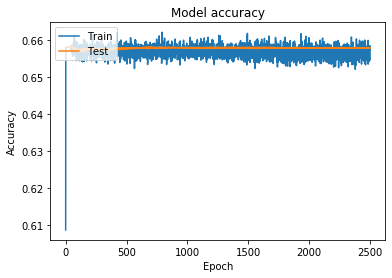

In [268]:

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

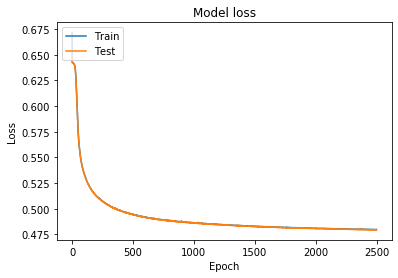

In [267]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()